## Importing Libraries

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import read_params

## Reading in the dataset

In [31]:
param_path = "../params.yaml"
config = read_params(param_path)
data = pd.read_csv(os.path.join("..", config["load_dataset"]["raw_dataset_path"]))
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


## Number of Data Points

In [32]:
print(f"We have {len(data)} numer of data points in our training data")

We have 404290 numer of data points in our training data


## Duplicate Analysis

In [33]:
print(f"Number of duplicate id's in qid1, {len(data) - data.qid1.nunique()}")
print(f"Number of duplicate id's in qid1, {len(data) - data.qid2.nunique()}")

Number of duplicate id's in qid1, 113636
Number of duplicate id's in qid1, 104926


In [34]:
print(f"Number of duplicate id pairs, {len(data[data[['qid1', 'qid2']].duplicated()])}")

Number of duplicate id pairs, 0


So questions are repeating, but the pairs of questions are unique

## Null Analysis

In [35]:
print(data.isna().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [37]:
data[data["question1"].isna() | data["question2"].isna()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


So there are 3 questions in total who have NaN in their question id.<br> Given that there are only 3 such questions we can drop them in our analysis, as well as drop them while cleaning the dataset

In [46]:
data.dropna(inplace=True)

## Question Statistics

### Question Length

In [51]:
data["que1_len"] = data["question1"].apply(lambda x: len(x))
data["que2_len"] = data["question2"].apply(lambda x: len(x))

In [53]:
print(f"median length in column question1 {data['que1_len'].median()}")
print(f"median length in column question2 {data['que2_len'].median()}")

median length in column question1 52.0
median length in column question2 51.0


In [55]:
print(f"minmum length in column question1 {min(data['que1_len'])}")
print(f"maximum length in column question1 {max(data['que1_len'])}")
print(f"minmum length in column question2 {min(data['que2_len'])}")
print(f"maximum length in column question2 {max(data['que2_len'])}")

minmum length in column question1 1
maximum length in column question1 623
minmum length in column question2 1
maximum length in column question2 1169


<AxesSubplot:xlabel='que1_len', ylabel='Density'>

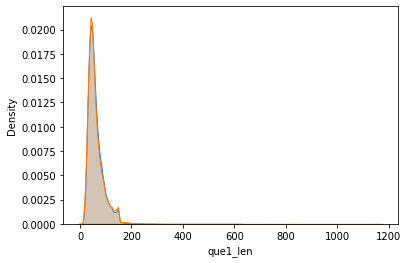

In [59]:
sns.kdeplot(x=data["que1_len"], shade=True)
sns.kdeplot(x=data["que2_len"], shade=True)

As we can see the distribution of the length of question 1 and 2 is almost similar

<AxesSubplot:>

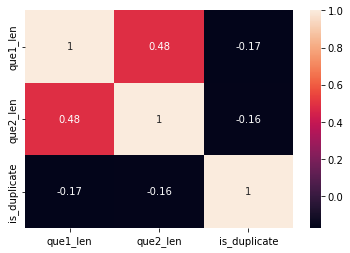

In [75]:
sns.heatmap(data[["que1_len", "que2_len", "is_duplicate"]].corr(), annot=True)

So the length of que1 and que2 doesn't have a lot of correlation with wether the questions are correlated or not

### Common Words

Here let's try to go ahead and see how target is affected with the question1 and question2 having similar words

In [90]:
def get_same_words_count(sent1, sent2):
    words1 = set(sent1.split())
    words2 = set(sent2.split())
    return len(words1.intersection(words2))

same_words_count = []
for x, y in data.iterrows():
    same_words_count.append(get_same_words_count(y.question1, y.question2))

data["same_words_count"] = same_words_count

<AxesSubplot:xlabel='same_words_count', ylabel='Density'>

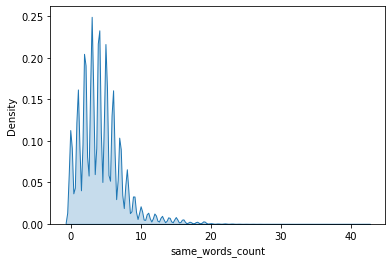

In [95]:
sns.kdeplot(x=data["same_words_count"], shade=True)

<AxesSubplot:>

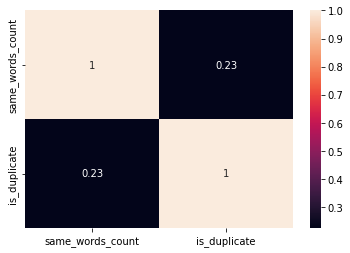

In [97]:
sns.heatmap(data[["same_words_count", "is_duplicate"]].corr(), annot=True)

So we can see the number of same words seems to be a little bit correlated with is_duplicate.<br>
We can perhaps improve this correlation a little bit more with some preprocessing, and using word frequencies instead of set.<br>
Although with the removal of stopwords perhaps the number of common words might reduce. We will perform this eda once more after the features are created.

## Target Statistics

/Users/adityajha/miniconda3/envs/quesimilarity/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

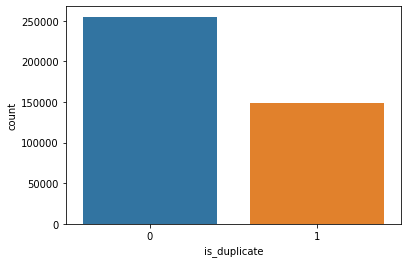

In [63]:
sns.countplot(data["is_duplicate"])

In [69]:
print(f"fraction of data points with label 0: {np.round(len(data[data['is_duplicate'] == 1])/len(data),2)}%")
print(f"fraction of data points with label 1: {np.round(len(data[data['is_duplicate'] == 0])/len(data),2)}%")

fraction of data points with label 0: 0.37%
fraction of data points with label 1: 0.63%


So we have a target data distribution skew where about 37% of the dataset has label of duplicate while the rest 67% of the dataset has the label of not-duplicate